# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. **Get probe template**
2. Get the Bragg disks
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 1: Get probe template

The aim here is to create a convolution kernel in the shape of the unscattered electron beam, which can then be used to identify the Bragg disks in each diffraction pattern of the datacube.  

Possible approaches include:
1. Use a scan region of the 4DSTEM datacube that was over vacuum (or perhaps thin amorphous support)
2. Use a separate 4DSTEM datacube take over vacuum
3. Create an artificial probe

Here, we demonstrate approach 1, proceeding as follows:

* Get average vacuum probe
    * Select an ROI over (nearly) vacuum
    * Find shifts of DPs within ROI relative to one reference DP
    * Register and average all DPs in ROI
* Create vacuum probe kernel
    * Mask probe outside of central disk
    * Get probe CoM and size
    * Normalize probe to integrate to 1
    * Subtract normalized 2D gaussian to get kernel integrating to 0
    * Center kernel in Fourier space (i.e. at corners of array)
* Save the vacuum probe kernel

### Import packages, load data

In [2]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.readwrite import save

In [4]:
# Load data
fp = "/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4"
dc = py4DSTEM.file.readwrite.read(fp)
dc.set_scan_shape(60,60)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error
dc.name = 'datacube'

/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4 is not a py4DSTEM file.  Reading with hyperspy...


### Get the average vacuum probe

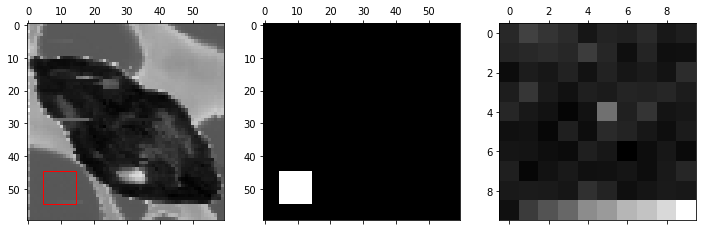

In [5]:
# Select ROI

xmin,xmax=45,55
ymin,ymax=5,15

ROI = np.zeros_like(dc.data4D[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
ave_im = np.average(dc.data4D,axis=(2,3))
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(ave_im,cmap='gray')
ax1.add_patch(roi_rect)
ax2.matshow(ROI,cmap='gray')
ax3.matshow(ave_im[ROI].reshape(xmax-xmin,ymax-ymin),cmap='gray')
plt.show()

In [6]:
# Get average, shift-corrected probe from ROI

mask_threshold = 0.2
mask_expansion = 12
mask_opening = 3
verbose = False

probe = get_average_probe_from_ROI(dc, ROI=ROI,
                                       mask_threshold=mask_threshold,
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening,
                                       verbose=verbose)

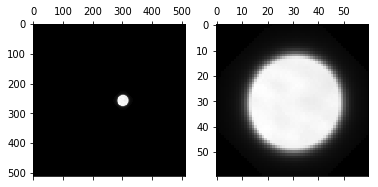

In [7]:
# Show average probe

rad = 30
xCoM_init,yCoM_init = get_CoM(probe)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

### Create vacuum probe kernel

In [8]:
sigma_probe_scale=4

probe_kernel = get_probe_kernel_subtrgaussian(probe, sigma_probe_scale=sigma_probe_scale)

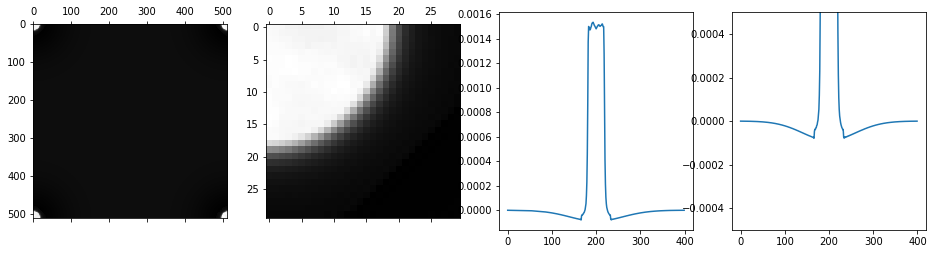

In [9]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length=200
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(dc.Q_Nx,dc.Q_Ny))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(16,4))
ax1.matshow(probe_kernel)
ax2.matshow(probe_kernel[:rad,:rad])
ax3.plot(np.arange(len(line_profile)),line_profile)
ax4.plot(np.arange(len(line_profile)),line_profile)
ax4.set_ylim(-0.0005,0.0005)
plt.show()

### Save the vacuum probe kernel

In [10]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
save([dc,probe_kernel],savepath)

Error: if data is a list, it must contain all ints or all DataObjects.
